# Train feedforward net

In [1]:
import src.midi_utils as midi_utils

import pygame

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
midi_filename = 'midi_data/bwv104.6.mid'
# midi_filename = 'midi_data/pkgsc_azalea.mid'
pygame.init()
pygame.mixer.music.load(midi_filename)
pygame.mixer.music.play()

In [3]:
pygame.mixer.music.stop()

# Neural network

In [4]:
from src.dataset_utils import TrackDataset, get_dataset_representation_from_tracks
from torch.utils.data import DataLoader

tracks = []
# iterate over all midi files of folder
import glob
import os

try:
    home_dir
except NameError:
    home_dir = os.getcwd()

os.chdir(home_dir + "/midi_data/bach")  # go to a folder relative to home dir
for midi_file in glob.glob("*.mid"):
    # get a list of all soprano tracks
    ## load midi file
    csv_text = midi_utils.load_to_csv(midi_file)

    ## Split into tracks
    track_dict = midi_utils.split_tracks(csv_text)
    track_nr = '1'

    ## Generating numpy array with notes
    track = midi_utils.midi_track_to_numpy(track_dict[track_nr])
    tracks.append(track)
    
print("Number of tracks: " + str(len(tracks)))

x, y = get_dataset_representation_from_tracks(tracks)

print("Number of samples: " + str(len(x)))

mini_batch_size = 32

# for now, we only train on the pitches of the notes
train_dataset = TrackDataset(x, y, drop_length=True)  # make training dataset
#validation_dataset = TrackDataset(val_images, val_centers)  # make validation dataset
#test_dataset = TrackDataset(test_images, test_centers)  # make test dataset

train_loader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)
validation_loader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True) # TODO TODO TODO: CHANGE TO A SUITABLE VALIDATIONSET
#test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

Number of tracks: 357
Number of samples: 17204


In [5]:
import torch
import torch.nn as nn
import numpy as np

print("Training set size", len(train_dataset))

input_size = len(train_dataset[0][0])  # get input size
input_example = train_dataset[0][0]
output_size = len(train_dataset[0][1])  # get output size
output_example = train_dataset[0][1]
learning_rate = 0.0001

print("Input size {}/ output size {}/ learning rate {}".format(input_size, output_size, learning_rate))
print("Input example {}".format(input_example))
print("Output example {}".format(output_example))


class LinearModel(nn.Module):

    def __init__(self, input_dimension, output_dimension):
        super(LinearModel, self).__init__()
        self.fc = torch.nn.Linear(input_dimension, output_dimension, bias=True)  # linear layer with parameters A, b

    def forward(self, input_data):
        output = self.fc(input_data)  # applies out = input * A + b. A, b are parameters of nn.Linear that we want to learn
        return output
    

class MLPModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, input):
        return self.layers(input)
    
device = torch.device('cpu')
    
# linear_model = LinearModel(input_size, output_size)
# 
# linear_model = linear_model.to(device)
# 
mlp_model = MLPModel(input_size, 64, output_size)

mlp_model = mlp_model.to(device)

model = mlp_model


criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


def train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function, device=torch.device('cpu'), verbose=1):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        # training phase
        model.train()
        # Iterate mini batches over training dataset
        losses = []
        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)  # predict output from input
            
            # set gradients to zero
            optimizer.zero_grad()

            loss = loss_function(output, y)
            if verbose > 2:
                print(loss.item())
            loss.backward()
            optimizer.step()

            # Metrics
            losses.append(loss.item())
            
        train_losses.append(np.mean(np.array(losses)))

        # Evaluation phase
        model.eval()
        # iterate mini batches over validation set
        # We don't need gradients
        losses = []
        with torch.no_grad():
            for x, y in val_dataloader:
                x = x.to(device)
                y = y.to(device)
                output = model(x)
                loss = loss_function(output, y)
                if verbose > 1:
                    print(loss.item())

                losses.append(loss.item())
        val_losses.append(np.mean(np.array(losses)))
        
        if verbose > 0:
            print('Epoch {}/{}: train_loss: {:.4f}, val_loss: {:.4f}'.format(epoch + 1, n_epochs, train_losses[-1], val_losses[-1]))
    return train_losses, val_losses


Training set size 17204
Input size 10/ output size 1/ learning rate 0.0001
Input example tensor([74., 77., 74., 74., 74., 74., 75., 74., 72., 72.])
Output example tensor([70.])


In [6]:
# Train the linear model and plot how the loss changes as the 
# training progresses for both training and validation set.
import matplotlib.pyplot as plt
%matplotlib inline

train_losses, val_losses = train(model, train_loader, validation_loader, optimizer, 50, criterion, verbose=1)

Epoch 1/50: train_loss: 6305.8225, val_loss: 4073.2958
Epoch 2/50: train_loss: 3666.7885, val_loss: 3286.9889
Epoch 3/50: train_loss: 2959.0862, val_loss: 2653.0380
Epoch 4/50: train_loss: 2388.7364, val_loss: 2141.6806
Epoch 5/50: train_loss: 1928.5474, val_loss: 1729.4296
Epoch 6/50: train_loss: 1557.6488, val_loss: 1397.0180
Epoch 7/50: train_loss: 1258.4068, val_loss: 1129.0132
Epoch 8/50: train_loss: 1017.1944, val_loss: 912.7777
Epoch 9/50: train_loss: 822.6472, val_loss: 738.5246
Epoch 10/50: train_loss: 665.8573, val_loss: 597.9620
Epoch 11/50: train_loss: 539.3505, val_loss: 484.6309
Epoch 12/50: train_loss: 437.3793, val_loss: 393.2572
Epoch 13/50: train_loss: 355.1409, val_loss: 319.5581
Epoch 14/50: train_loss: 288.8403, val_loss: 260.1792
Epoch 15/50: train_loss: 235.3840, val_loss: 212.2423
Epoch 16/50: train_loss: 192.2664, val_loss: 173.5866
Epoch 17/50: train_loss: 157.4595, val_loss: 142.4225
Epoch 18/50: train_loss: 129.4410, val_loss: 117.3084
Epoch 19/50: train_los

tensor([[67., 69., 67., 66., 66., 66., 67., 67., 69., 69.],
        [73., 71., 73., 66., 68., 69., 71., 69., 74., 74.],
        [71., 73., 75., 76., 76., 78., 75., 76., 76., 76.],
        [74., 72., 70., 72., 72., 74., 70., 72., 74., 75.],
        [74., 70., 79., 75., 77., 70., 75., 72., 70., 72.],
        [74., 75., 74., 72., 74., 67., 72., 70., 69., 70.],
        [74., 76., 74., 69., 74., 72., 70., 69., 67., 69.],
        [69., 67., 67., 69., 67., 66., 66., 66., 67., 67.],
        [76., 78., 76., 74., 73., 74., 73., 71., 71., 76.],
        [76., 71., 72., 69., 69., 64., 65., 64., 69., 68.],
        [70., 69., 67., 69., 65., 65., 70., 69., 67., 65.],
        [74., 74., 69., 71., 73., 74., 73., 71., 69., 74.],
        [71., 69., 71., 68., 68., 69., 71., 73., 71., 73.],
        [67., 69., 70., 69., 67., 65., 67., 69., 67., 69.],
        [74., 72., 71., 71., 69., 72., 72., 71., 69., 68.],
        [78., 78., 76., 71., 71., 72., 71., 69., 69., 67.],
        [70., 68., 67., 72., 72., 70., 7

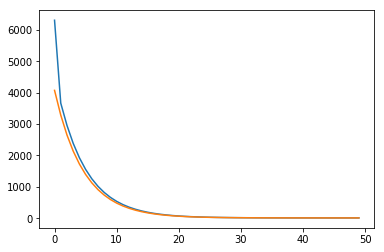

In [7]:
# check predictions from samples

for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    output = model(x)  # predict output from input

    print(x)
    print("\n")
    print(y)
    print(torch.mean(y).item())
    print("\n")
    print(output)
    break


plt.axis('on')
x = range(len(train_losses))
plt.plot(x, train_losses, x, val_losses)

plt.show()

In [8]:
# predict midi from init samples

init_sample, _ = train_dataset[0]  # some sample
x = init_sample.to(device)

generated_track = x.clone()

# predict for a certain length
predict_length = 30  # TODO: Model the end of the songs as well through a terminator.

for i in range(predict_length):
    y = model(x)  # predict output from input
    x = torch.cat((x[1:], y))  # shift the input by one by adding the prediction
    generated_track = torch.cat((generated_track, y.round()))  # append prediction to generated track
    
track = generated_track.detach().numpy()

print(track)


[74. 77. 74. 74. 74. 74. 75. 74. 72. 72. 70. 70. 70. 70. 70. 70. 70. 70.
 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70.
 70. 70. 70. 70.]


In [9]:
# write numpy to midi track

numpy_notes = midi_utils.prediction_to_numpy(track, 1024)

# create midi track
new_track = midi_utils.numpy_to_midi_track(numpy_notes, 1, 'Modified')

print(numpy_notes)

os.chdir(home_dir)

# make new song with the new track
new_track_dict = {}
new_track_dict['0'] = track_dict['0']
new_track_dict['1'] = new_track
modified_midi_filename = 'midi_data/test_modified_track.mid'
modified_csv_list = midi_utils.track_dict_to_csv(new_track_dict)
midi_utils.write_to_midi(modified_csv_list, modified_midi_filename)

[[  74. 1024.]
 [  77. 1024.]
 [  74. 1024.]
 [  74. 1024.]
 [  74. 1024.]
 [  74. 1024.]
 [  75. 1024.]
 [  74. 1024.]
 [  72. 1024.]
 [  72. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]
 [  70. 1024.]]


In [12]:
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

In [13]:
pygame.mixer.music.stop()